In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.models as models
import numpy as np
import datasets.labels as l

from datasets.cityscapes import setupDatasetsAndLoaders

In [2]:
# CUDA check
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
# device = "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


In [3]:
print(torch.__version__)

1.4.0


### Datasets and Dataloader

In [4]:
'''
Input:
inp(nd_array): 1024x2048 image to be visualized
label(nd_array): label for the 1024x2048 image
Function:
output the correct colours for the labels, and for the pixels that are 255 in the label, it will show the 255 colour instead
'''
def convertColour(inp, label):
    np_inp = inp.numpy()
    label = label.numpy()
    final = []
    for i, i_label in zip(np_inp, label):
        out = []
        for j, j_label in zip(i, i_label):
            if j_label == 255:
                out.append(l.trainId2color[j_label])
            else:
                out.append(l.trainId2color[j])
        final.append(out)
    return np.asarray(final)

In [61]:
# IOU function
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):   
    iou_class={}
    for i in range(19):
        output_class_h = outputs[0][i] 
        output_class = torch.unsqueeze(output_class_h,0)
        output_class= output_class.type(labels.dtype)

        intersection = (output_class & labels).float().sum((1, 2))
        union = (output_class | labels).float().sum((1, 2))  
        
        iou = (intersection + SMOOTH) / (union + SMOOTH) 
        iou_class[i]=iou
    return sum(list(iou_class.values()))/19 

image name: ('ulm_000058_000019_leftImg8bit',)
image tensor size: torch.Size([1, 3, 224, 448])
annotated output tensor size: torch.Size([1, 224, 448])


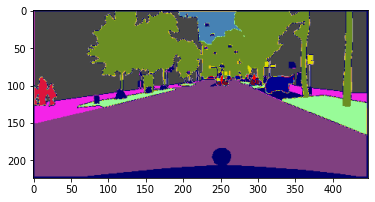

In [5]:
train_set, val_set, test_set, train_loader, val_loader, test_loader = setupDatasetsAndLoaders('./data', batch_size=1)

for sample in train_loader:
    imgSeq, annotatedOutput, imgName = sample

    print(f'image name: {imgName}')
    print(f'image tensor size: {imgSeq[-1].shape}')
    print(f'annotated output tensor size: {annotatedOutput.shape}')

#     plt.imshow(imgSeq[-1][0].permute(1, 2, 0))
#     print(annotatedOutput[0,200:400,0:200])
    plt.imshow(annotatedOutput[0])
    plt.imshow(convertColour(annotatedOutput[0],annotatedOutput[0]))
    break

### Model

In [55]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# Define AutoEncoder Model for MNIST
class MNIST_Autoencoder(nn.Module):

    def __init__(self, num_classes=19):
        
        # Init from nn.Module
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
#         self.vgg16 = models.vgg16(pretrained=False)
        self.classifier32 = nn.Sequential(nn.Conv2d(512, 512, 1),
                                         nn.Conv2d(512,num_classes, 1))
        self.classifier16 = nn.Sequential(nn.Conv2d(256, 256, 1),
                                         nn.Conv2d(256,num_classes, 1))
        self.classifier8 = nn.Sequential(nn.Conv2d(128, 128, 1),
                                         nn.Conv2d(128,num_classes, 1))
        self.deconv = nn.ConvTranspose2d(num_classes*2, num_classes, 32, stride=32)
        self.deconv32 = nn.ConvTranspose2d(num_classes*2, num_classes, 4, stride=2, padding=1)
        self.deconv16 = nn.ConvTranspose2d(num_classes*2, num_classes, 4, stride=2, padding=1)
        self.deconv8 = nn.ConvTranspose2d(num_classes*2, num_classes, 8, stride=8)
        self.lstm = nn.LSTM(num_classes*7*14, num_classes*7*14)
        self.flatten = nn.Flatten()
        

    def forward(self,x):
#         print(x.shape)
        res = []
        for ind,x1 in enumerate(x):
            x1 = self.resnet18.conv1(x1)
            x1 = self.resnet18.bn1(x1)
            x1 = self.resnet18.relu(x1)
            x1 = self.resnet18.maxpool(x1)
            x1 = self.resnet18.layer1(x1)
#             print(x1.shape)
            x1 = self.resnet18.layer2(x1)
#             print(x1.shape)
            if ind == 3:
                x4_8 = self.classifier8(x1)
                x4_8 = x4_8
            x1 = self.resnet18.layer3(x1)
#             print(x1.shape)
            if ind == 3:
                x4_16 = self.classifier16(x1)
                x4_16 = x4_16
            x1 = self.resnet18.layer4(x1)
#             print(x1.shape)
#             print(x1.shape)
            x1 = self.classifier32(x1)
#             print(x1.shape)
            if ind == 3:
                x4_32 = x1
            x1 = self.flatten(x1)
#             print(x1.shape)
            res.append(x1)

        x = torch.stack(res,1)
#         print(x.shape)
        
        x, _ = self.lstm(x)
#         print(x[:,3,:].shape)
        
        x = x[:,3,:].reshape(-1, 19, 7, 14)
#         print(x.shape)
#         print(x4.shape)
        x = torch.cat([x,x4_32],1)
#         print(x.shape)
        x = self.deconv32(x)
#         print(x.shape)
    
        x = torch.cat([x,x4_16],1)
        x = self.deconv16(x)
#         print(x.shape)
        
        x = torch.cat([x,x4_8],1)
        x = self.deconv8(x)

#         print(x.shape)
        return x

### Train

In [56]:
# Initialize MNIST Autoencoder
torch.manual_seed(10)
model = MNIST_Autoencoder().to(device)

torch.Size([1, 64, 56, 112])
torch.Size([1, 128, 28, 56])
torch.Size([1, 256, 14, 28])
torch.Size([1, 512, 7, 14])
torch.Size([1, 64, 56, 112])
torch.Size([1, 128, 28, 56])
torch.Size([1, 256, 14, 28])
torch.Size([1, 512, 7, 14])
torch.Size([1, 64, 56, 112])
torch.Size([1, 128, 28, 56])
torch.Size([1, 256, 14, 28])
torch.Size([1, 512, 7, 14])
torch.Size([1, 64, 56, 112])
torch.Size([1, 128, 28, 56])
torch.Size([1, 256, 14, 28])
torch.Size([1, 512, 7, 14])
torch.Size([1, 19, 14, 28])
torch.Size([1, 19, 28, 56])
torch.Size([1, 19, 224, 448])


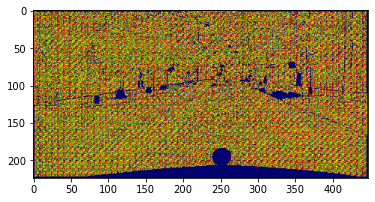

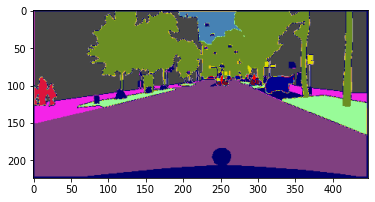

In [54]:
for sample in train_loader:
    imgSeq, annotatedOutput, imgName = sample
    for ind in range(4):
        imgSeq[ind] = imgSeq[ind].to(device)
    output = model(imgSeq)
    plt.imshow(convertColour(torch.max(output[0].cpu(), 0).indices, annotatedOutput[0].cpu()))
    plt.show()
    plt.imshow(convertColour(annotatedOutput[0].cpu(), annotatedOutput[0].cpu()))
    plt.show()
    break

In [57]:
# Defining Parameters
# - MSE Loss, which will be our reconstruction loss for now
# - Adam as optimizer
# - 20 Epochs
# - 128 as batch size
num_epochs = 20
batch_size = 128
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(),weight_decay = 1e-5)

100%|██████████| 66/66 [00:30<00:00,  2.15it/s]


epoch 1/20, loss 0.2371, val_loss 0.2699, train IoU 4.4913, val IoU -0.0474


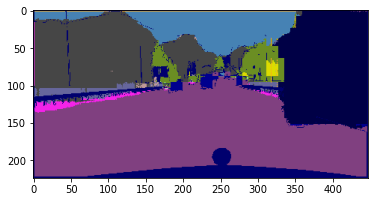

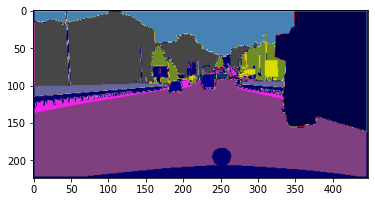

100%|██████████| 66/66 [00:30<00:00,  2.16it/s]


epoch 2/20, loss 0.2243, val_loss 0.2598, train IoU 30.9344, val IoU 1.4536


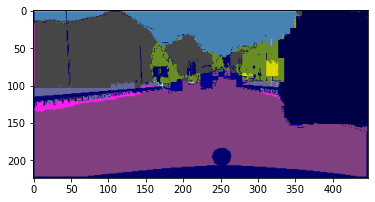

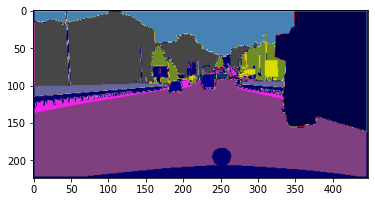

100%|██████████| 66/66 [00:30<00:00,  2.18it/s]


epoch 3/20, loss 0.2175, val_loss 0.2476, train IoU 6.5607, val IoU 2.7522


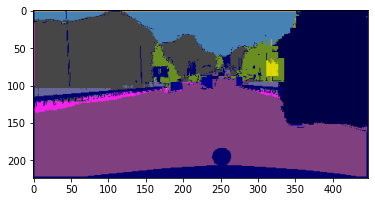

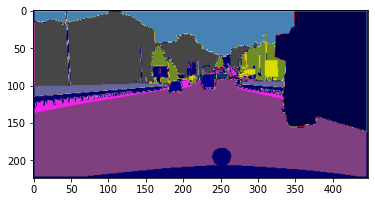

100%|██████████| 66/66 [00:30<00:00,  2.16it/s]


epoch 4/20, loss 0.2116, val_loss 0.2525, train IoU 1.4396, val IoU 5.8941


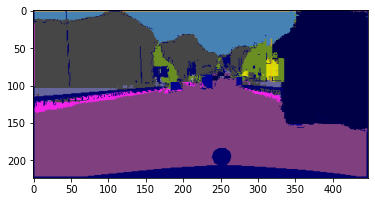

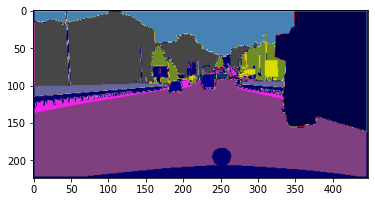

 48%|████▊     | 32/66 [00:15<00:16,  2.12it/s]


KeyboardInterrupt: 

In [70]:
# Train
model.train()
outputs_list = []
loss_list = []
val_loss_list = []
train_iou = []
val_iou = []
for epoch in range(num_epochs):
    running_train_loss = 0
    running_val_loss = 0
    running_train_iou = 0
    running_val_iou = 0
    model.train()
    for data in tqdm(train_loader):
        imgSeq, annotatedOutput, imgName = data
        
        # Send data to device
        for ind in range(4):
            imgSeq[ind] = Variable(imgSeq[ind]).to(device)
#         img = Variable(imgSeq[-1]).to(device)
        
        # Forward pass
        output = model(imgSeq)
        annotatedOutput = annotatedOutput.to(device).long()
#         output = output.argmax(dim=1)
        loss = loss_fn(output, annotatedOutput)
        running_train_loss+=loss.item()*output.shape[0]
        iou_mean = iou_pytorch(output, annotatedOutput)
        running_train_iou+=iou_mean.item()*output.shape[0]
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    for data_val in val_loader:
        imgSeq, annotatedOutput, imgName = data
        for ind in range(4):
            imgSeq[ind] = Variable(imgSeq[ind]).to(device)
        output = model(imgSeq)
        annotatedOutput = annotatedOutput.to(device).long()
        val_loss = loss_fn(output, annotatedOutput)
        val_iou_mean = iou_pytorch(output, annotatedOutput)
        running_val_loss+=val_loss.item()*output.shape[0]
        running_val_iou+=val_iou_mean.item()*output.shape[0]
    # Display
    print('epoch {}/{}, loss {:.4f}, val_loss {:.4f}, train IoU {:.4f}, val IoU {:.4f}'.format(
        epoch + 1, num_epochs, 
        running_train_loss/len(train_loader.dataset), 
        running_val_loss/len(val_loader.dataset), 
        running_train_iou/len(train_loader.dataset), 
        running_val_iou/len(val_loader.dataset)))
#     outputs_list.append((epoch, img, output),)

    loss_list.append(running_train_loss/len(train_loader.dataset))
    val_loss_list.append(running_val_loss/len(val_loader.dataset))
    train_iou.append(running_train_iou/len(train_loader.dataset))
    val_iou.append(running_val_iou/len(val_loader.dataset))
    
    # Save model here
    
    plt.imshow(convertColour(torch.max(output[0].cpu(), 0).indices, annotatedOutput[0].cpu()))
    plt.show()
    plt.imshow(convertColour(annotatedOutput[0].cpu(), annotatedOutput[0].cpu()))
    plt.show()

In [71]:
print(len(train_loader.dataset))

66


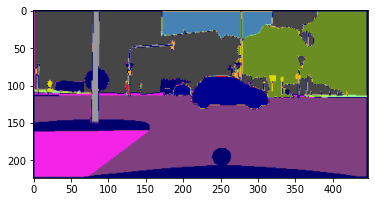

In [72]:
plt.imshow(convertColour(annotatedOutput[0].cpu(), annotatedOutput[0].cpu()))

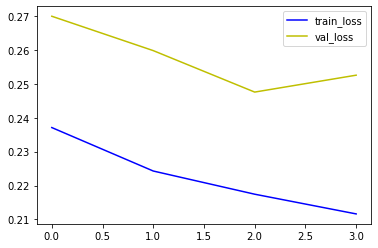

In [84]:
# Display loss
plt.figure()
plt.plot(loss_list, color='b', label='train_loss')
plt.plot(val_loss_list, color='y', label='val_loss')
plt.legend()
plt.show()

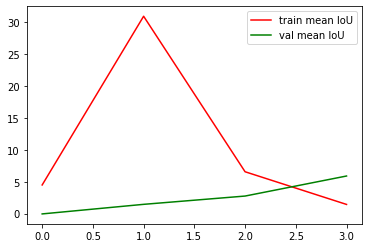

In [85]:
# Display Iou
plt.figure()
plt.plot(train_iou, color='r', label='train mean IoU')
plt.plot(val_iou, color='g', label='val mean IoU')
plt.legend()
plt.show()